#### 통합코드 작성 및 결과 도출 
- 매수 및 매도 전략

09:01:26 - cmdstanpy - INFO - Chain [1] start processing
09:01:27 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


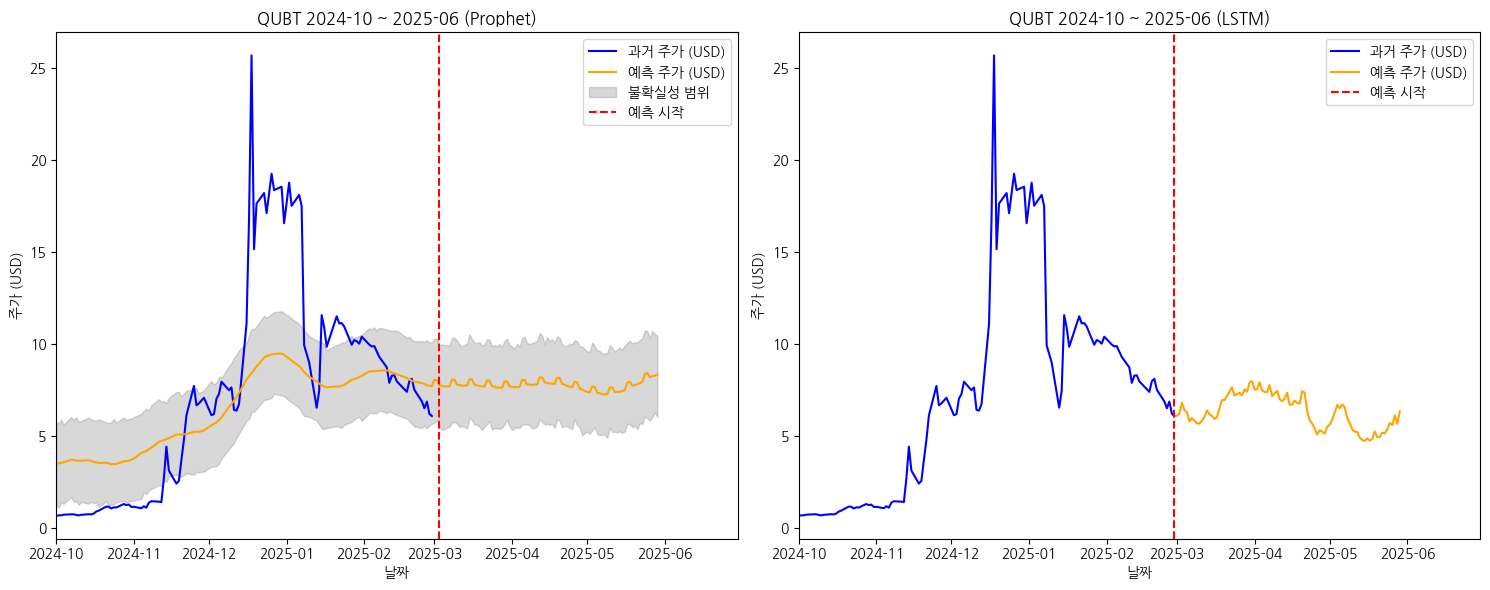

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 가져오기
stock = yf.Ticker("QUBT")
data = stock.history(start="2020-01-01", end="2025-03-03")
data.index = data.index.tz_localize(None)  # 타임존 제거
prices = data['Close'].values.reshape(-1, 1)

# Prophet 준비 및 학습
prophet_data = data[['Close']].reset_index()
prophet_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
prophet_data['ds'] = prophet_data['ds'].dt.tz_localize(None)
model_prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
model_prophet.fit(prophet_data)
future_prophet = model_prophet.make_future_dataframe(periods=90)
forecast_prophet = model_prophet.predict(future_prophet)

# LSTM 준비 및 학습
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)
look_back = 30
X, y = [], []
for i in range(look_back, len(scaled_prices)):
    X.append(scaled_prices[i-look_back:i, 0])
    y.append(scaled_prices[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:]
y_train, y_test = y[0:train_size], y[train_size:]
model_lstm = Sequential()
model_lstm.add(LSTM(100, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# LSTM 예측
volatility_base = np.std(np.diff(data['Close']))
volatility = volatility_base * 0.5
last_sequence = scaled_prices[-look_back:]
future_predictions_lstm = []
current_sequence = last_sequence.copy()
for _ in range(90):
    next_pred_scaled = model_lstm.predict(current_sequence.reshape(1, look_back, 1), verbose=0)[0, 0]
    next_pred = scaler.inverse_transform([[next_pred_scaled]])[0, 0]
    noise = np.random.normal(0, volatility, 1)[0]
    next_pred += noise
    next_pred_scaled = scaler.transform([[next_pred]])[0, 0]
    future_predictions_lstm.append(next_pred)
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[-1] = next_pred_scaled

# 2024-10-01 ~ 2025-06-30 필터링
start_date = pd.to_datetime('2024-10-01')
end_date = pd.to_datetime('2025-06-30')
mask_prophet = (forecast_prophet['ds'] >= start_date) & (forecast_prophet['ds'] <= end_date)
forecast_prophet_filtered = forecast_prophet[mask_prophet]
past_mask_prophet = (prophet_data['ds'] >= start_date) & (prophet_data['ds'] <= end_date)
prophet_data_filtered = prophet_data[past_mask_prophet]
mask_data = (data.index >= start_date) & (data.index <= end_date)
data_filtered = data[mask_data]

# 시각화 (subplot)
plt.figure(figsize=(15, 6))

# Prophet subplot
plt.subplot(1, 2, 1)
plt.plot(prophet_data_filtered['ds'], prophet_data_filtered['y'], label="과거 주가 (USD)", color='blue')
plt.plot(forecast_prophet_filtered['ds'], forecast_prophet_filtered['yhat'], label="예측 주가 (USD)", color='orange')
plt.fill_between(forecast_prophet_filtered['ds'], forecast_prophet_filtered['yhat_lower'], 
                 forecast_prophet_filtered['yhat_upper'], color='gray', alpha=0.3, label="불확실성 범위")
plt.axvline(x=pd.to_datetime("2025-03-03"), color='r', linestyle='--', label="예측 시작")
plt.xlim(start_date, end_date)
plt.title("QUBT 2024-10 ~ 2025-06 (Prophet)")
plt.xlabel("날짜")
plt.ylabel("주가 (USD)")
plt.legend()

# LSTM subplot
plt.subplot(1, 2, 2)
plt.plot(data_filtered.index, data_filtered['Close'], label="과거 주가 (USD)", color='blue')
future_dates = pd.date_range(start=data.index[-1], periods=91, freq='D')[1:]
plt.plot(future_dates[:90], future_predictions_lstm, label="예측 주가 (USD)", color='orange')
plt.axvline(x=data.index[-1], color='r', linestyle='--', label="예측 시작")
plt.xlim(start_date, end_date)
plt.title("QUBT 2024-10 ~ 2025-06 (LSTM)")
plt.xlabel("날짜")
plt.ylabel("주가 (USD)")
plt.legend()

plt.tight_layout()
plt.show()

#### 최종 결론
- **단기 (2024-10 ~ 2025-06)**: LSTM이 더 설득력. `volatility = volatility_base * 0.5`로 조정해 토스증권 주가와 유사한 패턴(7.0~8.0 USD 변동성) 반영. 매수(7.0~7.2 USD), 매도(8.0 USD).
- **장기**: Prophet이 트렌드와 계절성 기반으로 4년 묵히기(2029년 15~20 USD 기대)에 적합.
- **전략**: 단기 투자자는 LSTM 활용, 장기 투자자는 Prophet 기반 4년 보유. 손절 6.5 USD, 투자 비율 20~30%.